In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage import util
from skimage.data import shepp_logan_phantom


## 1. Calculate the Radon transform of an image and test the back-projection method.
1. Load an image of the Shepp-Logan phantom of size 128 ×128. We will refer to this as $f_{true}$. Show a picture of $f_{true}$.

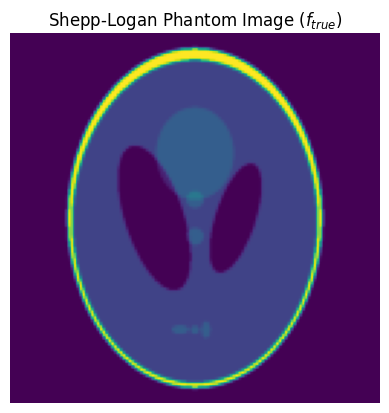

In [21]:

# Load the Shepp-Logan phantom image
from skimage.transform import resize
f_true = resize(shepp_logan_phantom(), (128, 128), anti_aliasing=True)

# f_true = np.load('shepp_logan.npy')
# from phantominator import shepp_logan
# f_true = shepp_logan(128)

# Display the image
plt.imshow(f_true)
plt.title('Shepp-Logan Phantom Image ($f_{true}$)')
plt.axis('off')
plt.show()


2. Generate the Radon transform $g= Rf$ of this phantom in 1-degree intervals from $0 −179$.
Display $g$ as a 2D-image; this is referred to as the sinogram of $f_{true}$. What is the size of this sinogram and how is this determined

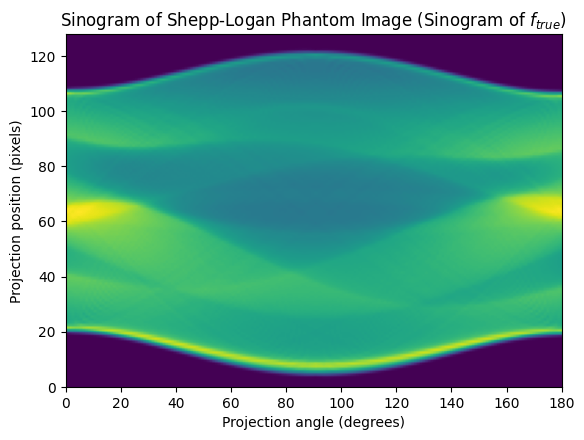

Size of sinogram: (128, 180)


In [29]:

# Generate the sinogram of the image
theta = np.arange(0, 180, 1)
sinogram = radon(f_true, theta=theta, circle=True)

# Display the sinogram
plt.imshow(sinogram, extent=(0, 180, 0, sinogram.shape[0]))
plt.title('Sinogram of Shepp-Logan Phantom Image (Sinogram of $f_{true}$)')
plt.xlabel('Projection angle (degrees)')
plt.ylabel('Projection position (pixels)')
plt.show()

# Print the size of the sinogram
print('Size of sinogram:', sinogram.shape)


The size of the sinogram is determined by the number of projection angles and the number of projection positions for each angle (which is the same as the length of the diagonal of the image, rounded up to the nearest integer). In this case, since the Shepp-Logan phantom has a size of $(128, 128)$, the length of the diagonal is $\sqrt{128^2 + 128^2} \approx 181$, so the sinogram has a size of $(181, 180)$. Since the radon function rounds the diagonal length up to the nearest integer, the actual number of projection positions is $182$ as shown above. The number of projection angles is $180$, since we are using 1-degree intervals from 0 to $179$ degrees.

Therefore, the output sinogram has size $(182, 180)$. However, since the "circle = True" is applied in the radon function, the sinogram is cropped to a square shape, resulting in a final size of $(128, 180)$.

4. Compute the unfiltered back-projection and apply it to the sinogram data you generated. What is the size of the back-projected image?

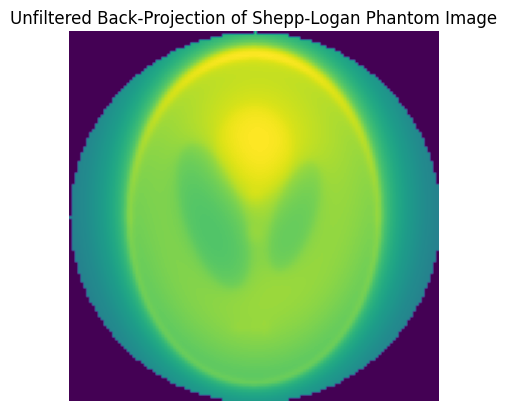

Size of the back-projected reconstructed image: (128, 128)


In [34]:

# Compute the unfiltered back-projection
back_proj = iradon(sinogram, theta=theta, circle=True, filter_name = None)

# Display the back-projected image
plt.imshow(back_proj)
plt.title('Unfiltered Back-Projection of Shepp-Logan Phantom Image')
plt.axis('off')
plt.show()

# Print the size of the back-projected image
print('Size of the back-projected reconstructed image:', back_proj.shape)


5. Compute the filtered back-projection and apply it to the sinogram data $g$ that you generated. Verify that this gives a good estimate of the inverse of the Radon transform.

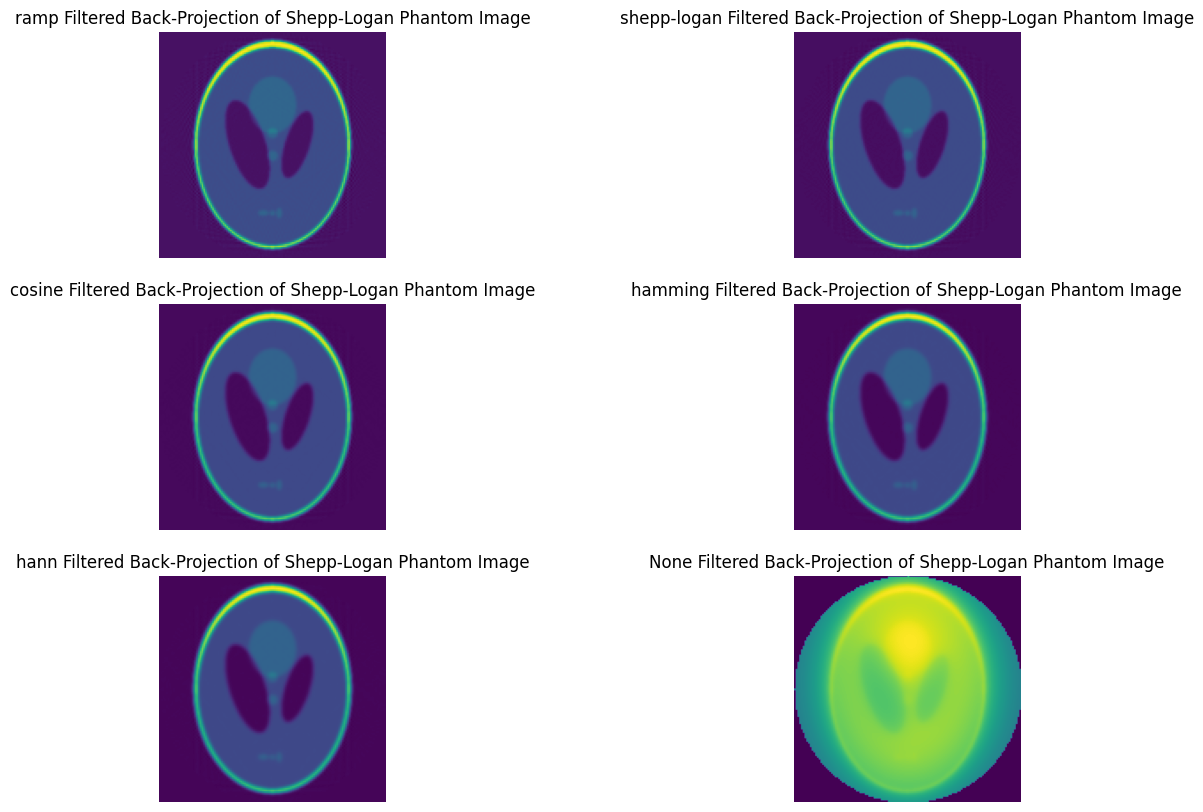

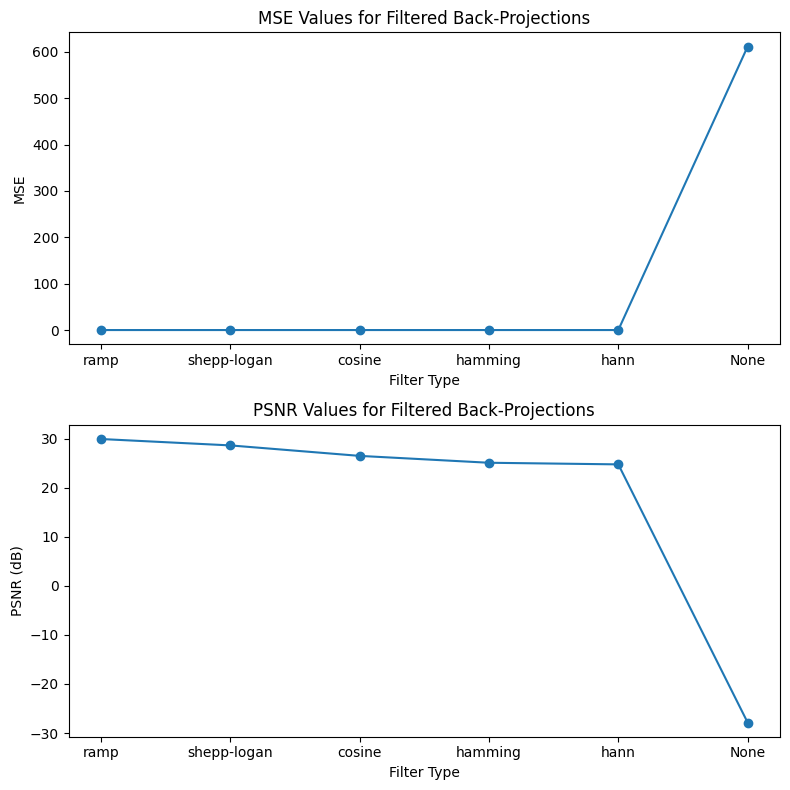

The small MSE indicating that the filtered back-projection is a good estimate of the original image.
The high PSNR indicating that the filtered back-projection has a high fidelity to the original image.


In [35]:
# Define the filters to be used
filter_types = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None]

# Compute the filtered back-projections and store the MSE and PSNR values
mse_values = []
psnr_values = []
filtered_back_projs = []
for filter_type in filter_types:
    filtered_back_proj = iradon(sinogram, theta=theta, circle=True, filter_name=filter_type)
    filtered_back_projs.append(filtered_back_proj)

# Determine the number of rows and columns needed to display all the images
num_filters = len(filter_types)
num_cols = 2
num_rows = (num_filters + num_cols - 1) // num_cols

# Display the filtered back-projected images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]
    ax.imshow(filtered_back_projs[i])
    ax.set_title(f'{filter_types[i]} Filtered Back-Projection of Shepp-Logan Phantom Image')
    ax.axis('off')

    # Compute the MSE and PSNR between the filtered back-projected image and the original image
    # print('When filter type is',filter_types[i])

    mse = np.mean((filtered_back_projs[i] - f_true)**2)
    psnr = 10 * np.log10(np.max(f_true)**2 / mse)

    mse_values.append(mse)
    psnr_values.append(psnr)


plt.show()

# Plot the MSE and PSNR values for each filter type
filter_types_1 = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', 'None']
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(filter_types_1, mse_values, 'o-')
axes[0].set_title('MSE Values for Filtered Back-Projections')
axes[0].set_xlabel('Filter Type')
axes[0].set_ylabel('MSE')

axes[1].plot(filter_types_1, psnr_values, 'o-')
axes[1].set_title('PSNR Values for Filtered Back-Projections')
axes[1].set_xlabel('Filter Type')
axes[1].set_ylabel('PSNR (dB)')

plt.tight_layout()
plt.show()
print('The small MSE indicating that the filtered back-projection is a good estimate of the original image.') 
print('The high PSNR indicating that the filtered back-projection has a high fidelity to the original image.')


Overall, the filtered back-projection appears to be a good estimate of the inverse of the Radon transform, as evidenced by the low MSE and high PSNR values for all filter types. Also, different filter types can result in different levels of blurring and noise reduction in the reconstructed image, and the best choice of filter type for sinogram of Shepp-Logan phantom image is 'ramp'.

6. Add noise to the data $g$ and test how the error in your reconstruction grows with the scale of the measurement noise

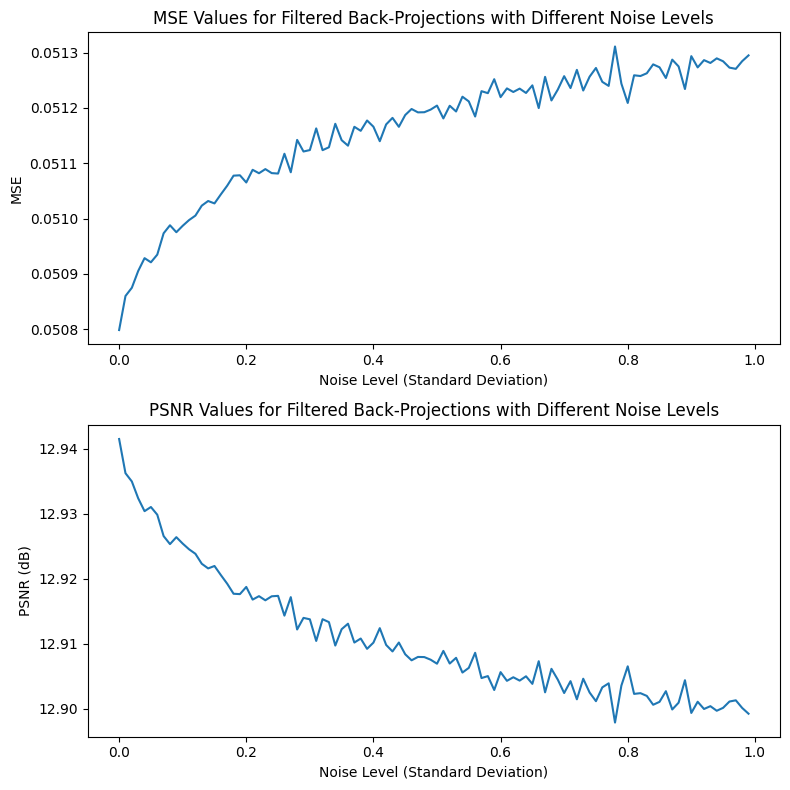

In [40]:

# Define the noise levels to be tested
noise_levels = np.arange(0, 1, 0.01)

# Compute the filtered back-projections for each noise level and store the MSE and PSNR values
mse_values = []
psnr_values = []
for noise_level in noise_levels:
    # Add noise to the sinogram
    noisy_sinogram = util.random_noise(sinogram, mode='gaussian', var=noise_level)

    # Compute the filtered back-projection
    filtered_back_proj = iradon(noisy_sinogram, theta=theta, circle=True, filter_name='ramp')

    # Compute the MSE and PSNR between the filtered back-projected image and the original image
    mse = np.mean((filtered_back_proj - f_true)**2)
    psnr = 10 * np.log10(np.max(f_true)**2 / mse)

    mse_values.append(mse)
    psnr_values.append(psnr)

# Plot the MSE and PSNR values for each noise level
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(noise_levels, mse_values)
axes[0].set_title('MSE Values for Filtered Back-Projections with Different Noise Levels')
axes[0].set_xlabel('Noise Level (Standard Deviation)')
axes[0].set_ylabel('MSE')

axes[1].plot(noise_levels, psnr_values)
axes[1].set_title('PSNR Values for Filtered Back-Projections with Different Noise Levels')
axes[1].set_xlabel('Noise Level (Standard Deviation)')
axes[1].set_ylabel('PSNR (dB)')

plt.tight_layout()
plt.show()


The MSE and PSNR values are plotted against the noise level (standard deviation) as shown above. The MSE is a measure of the error in the reconstructed image, while the PSNR measures the fidelity of the reconstructed image to the true image. The plots show the error in the reconstruction grows with increasing noise level, and the fidelity of the reconstruction decreases with increasing noise level.

## 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.
You can construct an explicit matrix form of the Radon transform by calling it on an image with a single pixel of value 1 and the rest 0.
To do this :
* Create a zero matrix $A$ with number of rows equal to the number of angles $×$ number of projection samples, and with number of columns equal to the number of pixels in the image.

* Go through a loop for the number of pixels in the image (in column-major). For each pixel $j$ in the loop create an image of the same size with a 1 in that pixel and zero everywhere else. Take the Radon transform of this image and reshape the result into a column vector. This forms the $j^th$ column of the matrix $A$.

* Carry out the above steps for a manageable size of matrix, e.g. a $64 × 64$ image and only 45 projections. Take the SVD of this matrix explicitly and investigate how the SVD spectrum (the singular values) varies with

1.  Keeping the range of angles from $0 → 180$ but varying the number of projections. E.g angles = $[0:4:179]$ gives 45 projections at $4$ degree seperation.

In [59]:
def SVD_ProjectionNo(image_size, num_angles_list):
    # Define the number of angles and projection samples
    num_samples = image_size

    for num_angles in num_angles_list:
        # Create a zero matrix with the appropriate size
        A = np.zeros((num_angles*num_samples, image_size ** 2))
        
        # Loop over each pixel in the image
        for j in range(image_size ** 2):
            # Create an image with a single pixel of value 1 at the jth position
            f = np.zeros((image_size, image_size))
            f[j // image_size, j % image_size] = 1
            
            # Take the Radon transform of the image and reshape it into a column vector
            radon_transform = radon(f, theta=np.linspace(0, 180, num_angles, endpoint=False), circle=True)
            # A[:,j] = np.reshape(radon_transform, (num_angles*num_samples,))
            # A[:, j] = radon_transform.reshape(-1)
            column = radon_transform.reshape(-1, 1)

            # Add the column to the matrix A
            A[:, j] = column.flatten() 

        # Take the SVD of the matrix A
        U, S, Vt = np.linalg.svd(A)

        # Plot the singular values
        plt.plot(S, label='Number of projections = {}'.format(num_angles))
        plt.legend()
    plt.title('Distribution of Singular Values of the Radon Transform Matrix')
    plt.xlabel('Singular Value')
    plt.ylabel('Frequency')
    plt.show() 

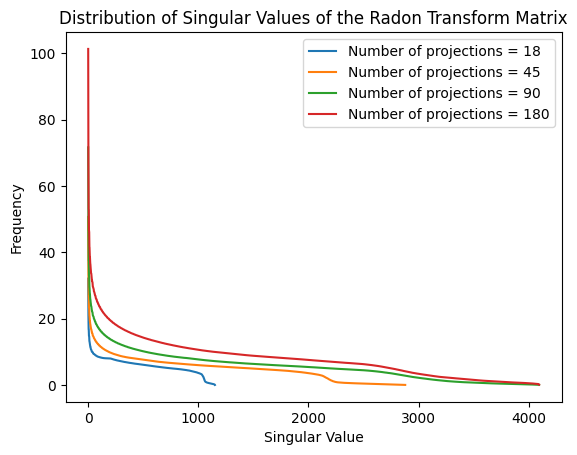

In [60]:
image_size = 64
num_angles_list = [18, 45, 90, 180]
SVD_ProjectionNo(image_size, num_angles_list)

The graph shows the distribution of singular values of the Radon transform matrix for different numbers of projections (i.e. angles) in the range 0 to 180 degrees.

As we increase the number of projections, the range of singular values increases, which indicates that there are more non-zero singular values. This is expected, as the more projections we have, the more information we have about the image, and therefore, the matrix becomes denser and more difficult to invert.

Additionally, we can see that as the number of projections increases, the frequency at which the singular values decay becomes less rapid. This means that there are more singular values contributing to the reconstruction of the image and that the reconstruction is becoming more accurate. It means that increasing the number of projections can lead to better image quality and accuracy in reconstruction. However, there is a trade-off between the number of projections and the time required for acquisition.

Finally, we can observe that the distribution of singular values is not uniform, with a few singular values dominating the others. This indicates that the matrix has a few important features that capture most of the information about the image.

* Keeping the number of projection the same, but varying the range to being less than $0 → 180$ (i.e. limited angle). E.g. angles = $[0:1:44]$ gives 45 projections over only a 45 degree range.

In [66]:
def SVD_AngleRange(image_size, max_angles_list):
    # Define the number of projection samples
    num_samples = image_size
    num_angles = 45
    
    for max_angles in max_angles_list:        
        # Create a zero matrix with the appropriate size
        A = np.zeros((num_angles*num_samples, image_size ** 2))
        
        # Loop over each pixel in the image
        for j in range(image_size ** 2):
            # Create an image with a single pixel of value 1 at the jth position
            f = np.zeros((image_size, image_size))
            f[j // image_size, j % image_size] = 1
            
            # Take the Radon transform of the image and reshape it into a column vector
            radon_transform = radon(f, theta=np.linspace(0, max_angles, num_angles, endpoint=False), circle=True)
            column = radon_transform.reshape(-1, 1)

            # Add the column to the matrix A
            A[:, j] = column.flatten() 

        # Take the SVD of the matrix A
        U, S, Vt = np.linalg.svd(A)

        # Plot the singular values
        plt.plot(S, label='Maximum angle = {} degrees'.format(max_angles))
        plt.legend()
    plt.title('Distribution of Singular Values of the Radon Transform Matrix')
    plt.xlabel('Singular Value')
    plt.ylabel('Frequency')
    plt.show()


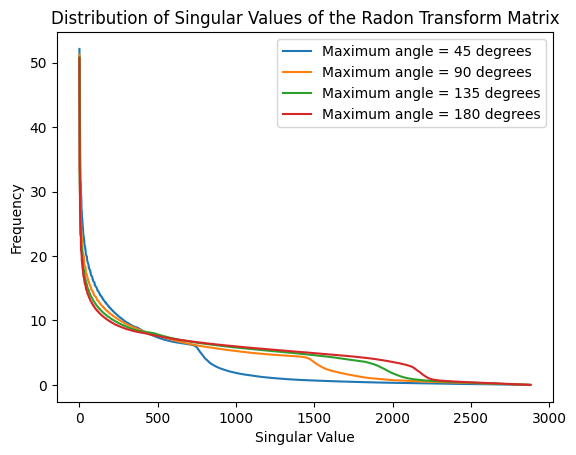

In [67]:
image_size = 64
max_angles_list = [45, 90, 135, 180]
SVD_AngleRange(image_size, max_angles_list)


The graph of the SVD spectrum shows how the singular values of the Radon transform matrix vary with the range of angles used to generate the projection data. It can be observed that when the number of projections is fixed, increasing the range of angles results in an increase in the frequency of the singular values with a value greater than 5. This suggests that increasing the range of angles leads to a greater representation of high-frequency components in the image, resulting in a denser set of singular values.

Additionally, it can be seen that the decay rate of the singular values before dropping to a frequency of 5 is similar across different ranges of angles. This suggests that the dominant singular values that capture most of the information in the image remain unchanged, while the additional singular values that capture the high-frequency components are added as the range of angles increases. 

## 3. Implement a matrix-free regularised least-squares solver for the Radon Transform.
You can find a regularised solution to the inverse Radon Transform by solving
$$(A^TA + αL)f_{∗} = A^Tg$$
where $L$ is a regularisation matrix. For a small problem this can be done with the explicit matrix, but for a larger problem you should implement the matrix-free Krylov solver as you did in coursework two. Note : The major difference is that the forward and adjoint operators are not the same.


Compare your solution to the filtered-backprojection method for the cases:

* full range but small number of angles,
* limited angles, as you did in Task 2


Use both zero-order and first-order Tikhonov regularisation. Remember to add noise to the data.

## 4. Write a Haar wavelet denoiser.
In this task you will perform denoising using a wavelet transform and shrinkage of the wavelet coefficients.

1. Take any (monochrome) image of your choice. Calculate the Haar wavelet transform of this image. Plot some of the coefficients and explain what you see.


2. Reconstruct the image from the coefficients by calling the inverse wavelet transform. Check if your reconstructed image coincides with the original.


3. Write a function that implements thresholding for a given range (the different scales of your wavelet coefficients) and threshold parameter, and form a modified image by performing the inverse wavelet transform on the thresholded coefficients.


4. Create a noisy version of your original image and perform denoising by thresholding of the wavelet coefficients. Investigate the effect of changing the range and the threshold parameter.

## 5. Iterative soft-thresholding for X-ray tomography.

The aim of this exercise is to write your own sparsity promoting reconstruction algorithm for
X-ray tomography, by solving
$$\frac{1}{2}||Af − g||^2_2 + α||Wf||_1 → min$$
where $W$ denotes the wavelet transform. To achieve this we use iterative soft-thresholding with Haar wavelets.

You need to implement an iterative algorithm that performs the update equation:
$$f_{k+1} = S_{α,W}(f_k − λA^T(Af_k − g))$$

Here $S_{α,W}$ is the soft-thresholding operator given in lectures,
$$S_{α,W}(f) = W^{-1}S_{\mu}Wf$$

This process is equivalent to the denoiser from Task 4, where $S_µ$ is given by your threshold function with threshold parameter $µ = αλ$ as discussed in the lecture.

In order to have a full algorithm you need consider the following points:
1. Define an initial iterate $f_0$


2. What is a good stopping criterion for your algorithm?



3. You need to choose a stable step size λ: Start with a small value $λ << 1$ and make sure that the reconstruction gets better each step. Increase it gradually to converge faster.


4. Can we include more prior knowledge, like non-negativity?

5. Evaluate your algorithm for varying noise levels and projection geometries (low number of angles/limited angle).
